In [3]:
## Imports

In [67]:
import pandas as pd 
import numpy as np
import re
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [86]:
def clean_value(x):
    if isinstance(x, str):
        x = x.replace('%', '').replace(',','.').strip()
    return float(x)

filepath = "/Users/jadendaily/Documents/IntroML/mlenv/Bond Pricing Project/data/bonds_eng.csv"
df = pd.read_csv(filepath, sep=";", encoding="latin1")
df.head()
cols = [
    "Coupon rate (eng)",
    "Maturity date",
    "Issue amount",
    "Price at primary placement",
    "Updating date"
]
df = df[cols].dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 1 to 9
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Coupon rate (eng)           8 non-null      object 
 1   Maturity date               8 non-null      object 
 2   Issue amount                8 non-null      int64  
 3   Price at primary placement  8 non-null      float64
 4   Updating date               8 non-null      object 
dtypes: float64(1), int64(1), object(3)
memory usage: 384.0+ bytes


In [69]:
df["Coupon rate (eng)"] = df["Coupon rate (eng)"].apply(clean_value)
df["Issue amount"] = df["Issue amount"].apply(clean_value)
df["Price at primary placement"] = df["Price at primary placement"].apply(clean_value)
df["Maturity date"] = pd.to_datetime(df["Maturity date"], dayfirst = True, errors = "coerce")
df["Updating date"] = pd.to_datetime(df["Updating date"], dayfirst = True, errors = "coerce")
df["Years to maturity"] = (df["Maturity date"] - df["Updating date"]).dt.days.astype(float) / 365
df = df[df["Years to maturity"] > 0].sort_values("Updating date")
df['price_1d'] = df['Price at primary placement'].rolling(window=1, min_periods=1).mean().astype(float)
df['price_7d'] = df['Price at primary placement'].rolling(window=7, min_periods=1).mean().astype(float)
df['price_30d'] = df['Price at primary placement'].rolling(window=30, min_periods=1).mean().astype(float)
df.head()

,Coupon rate (eng),Maturity date,Issue amount,Price at primary placement,Updating date,Years to maturity,price_1d,price_7d,price_30d
4,0.0,2027-06-30,1.970000e+08,68.500,2018-10-12,8.720548,68.500,68.500000,68.500000
3,5.5,2043-10-09,5.000000e+08,100.000,2019-09-02,24.117808,100.000,84.250000,84.250000
7,2.7,2047-03-01,1.720380e+10,99.182,2019-11-19,27.298630,99.182,89.227333,89.227333
8,6.5,2027-07-04,1.125000e+10,99.750,2019-11-27,7.605479,99.750,91.858000,91.858000
5,8.4,2030-05-21,2.000000e+10,100.000,2020-04-08,10.123288,100.000,93.486400,93.486400


In [70]:
scaling = ["Issue amount", "Years to maturity"]
df["Log Issue amount"] = np.log1p(df["Issue amount"])

In [71]:
df = df.sort_values("Updating date")
train = df[df["Updating date"] < "2023-01-01"]
test = df[df["Updating date"] >= "2023-01-01"]
features = [
    "Coupon rate (eng)",
    "Years to maturity",
    "Issue amount",
    "Price at primary placement",
    "Updating date"
]

In [72]:
split = int(len(df) * 0.8)
train = df.iloc[:split]
test = df.iloc[split:]

res = []
feature_set = {
    'no_history': ['Coupon rate (eng)', 'Years to maturity', 'Issue amount'],
    '1_day': ['Coupon rate (eng)', 'Years to maturity', 'Issue amount', 'price_1d'],
    '7_day': ['Coupon rate (eng)', 'Years to maturity', 'Issue amount', 'price_7d'],
    '30_day': ['Coupon rate (eng)', 'Years to maturity', 'Issue amount', 'price_30d']
}

In [73]:
for feature_name, features in feature_set.items():
    X_train = train[features].copy().astype(float)
    y_train = train["Price at primary placement"]
    X_test = test[features].copy().astype(float)
    y_test = test["Price at primary placement"]

    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_scaled, y_train)
    ridge_pred = ridge.predict(X_test_scaled)
    ridge_mae = mean_absolute_error(y_test, ridge_pred)
    ridge_r2 = r2_score(y_test, ridge_pred)

    gbr = GradientBoostingRegressor(n_estimators = 300, learning_rate = 0.05, max_depth = 3, random_state = 42)
    gbr.fit(X_train_scaled, y_train)
    gbr_pred = gbr.predict(X_test_scaled)
    gbr_mae = mean_absolute_error(y_test, gbr_pred)
    gbr_r2 = r2_score(y_test, gbr_pred)

    res.append({
        'Feature Set': feature_name,
        'Model': 'Ridge',
        'MAE': ridge_mae,
        'R2': ridge_r2
    })
    
    res.append({
        'Feature Set': feature_name,
        'Model': 'GradientBoosting',
        'MAE': gbr_mae,
        'R2': gbr_r2
    })

In [78]:
results_df = pd.DataFrame(res)
best_index = results_df["R2"].idxmax()
best_res = results_df.loc[best_index]
print(best_index)
print(best_res)

5
Feature Set               7_day
Model          GradientBoosting
MAE                    4.074057
R2                  -3509.67504
Name: 5, dtype: object


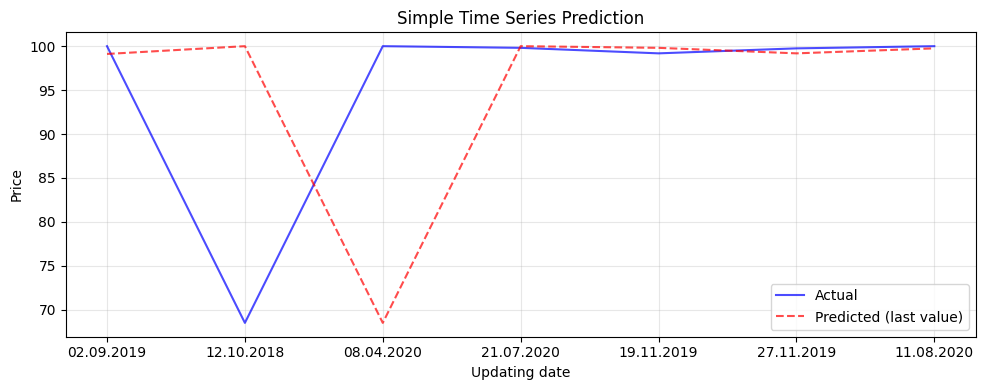

In [87]:
# plt.scatter(y_test, gbr_pred, alpha=0.4)
# plt.plot(
#     [y_test.min(), y_test.max()],
#     [y_test.min(), y_test.max()],
#     linestyle='-'
# )
# plt.xlabel("Actual primary placement price")
# plt.ylabel("Predicted Price")
# plt.title("Actual vs. Predicted Prices")
# plt.show()
df['pred_last'] = df['Price at primary placement'].shift(1)
df = df.dropna()
plt.figure(figsize=(10, 4))
plt.plot(df['Updating date'], df['Price at primary placement'], 'b-', alpha=0.7, label='Actual')
plt.plot(df['Updating date'], df['pred_last'], 'r--', alpha=0.7, label='Predicted (last value)')
plt.xlabel('Updating date')
plt.ylabel('Price')
plt.title('Simple Time Series Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()